In [4]:
#Gempy_Mesh
import gempy as gp
import gempy_viewer as gpv
import vtk
import rasterio
import pyevtk
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from scipy.interpolate import LinearNDInterpolator
from SimPEG import maps, inverse_problem, regularization, optimization, inversion, data_misfit, data, utils
from SimPEG.potential_fields import gravity
from SimPEG import discretize
import SimPEG.potential_fields as pf
from gempy.core.data import GeoModel
from gempy.core.data import Grid
from gempy.core.data.grid_modules import RegularGrid
import matplotlib as mpl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, time
import pyvista as pv
from gempy_engine.core.data.stack_relation_type import StackRelationType

In [5]:
nx, ny, nz= 20, 20, 20
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model1',
    extent=[853610.2891, 855569.4948, 
            987530.5888, 988620.4712, 
            -6600, 3000], #x, y, z
    resolution=[nx, ny, nz],
    refinement=4, # We will use octrees
    importer_helper= gp.data.ImporterHelper(
        path_to_orientations= "model_fault_orientation1.csv",
        path_to_surface_points= "model_fault_points.csv",
        # path_to_orientations= "Model_Orientations.csv",
        # path_to_surface_points= "Model_Points.csv",

    )
)

In [6]:
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object=  # TODO: This mapping I do not like it too much. We should be able to do it passing the data objects directly
    {
        "Strat_Series1": ('Complejo_Dacitico'),     
        "Strat_Series2": ('Edificio_Volcanico'),
        "Strat_Series3": ('Flujo_Piroclastico', 'Sucesion_Piroclastica', 'Sucesion_Volcanica')
    }
)
geo_model.structural_frame  # Display the resulting structural frame


StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Complejo_Dacitico,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Edificio_Volcanico,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strat_Series3,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Flujo_Piroclastico,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Sucesion_Piroclastica,
	color=#728f02,
	is_active=True
),
Element(
	name=Sucesion_Volcanica,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False, False],
 [False, False, False],
 [False, False, False]],

In [7]:
geo_model.grid

Grid(values=array([[853659.2692425, 987557.83586  ,  -6360.       ],
       [853659.2692425, 987557.83586  ,  -5880.       ],
       [853659.2692425, 987557.83586  ,  -5400.       ],
       ...,
       [855520.5146575, 988593.22414  ,   1800.       ],
       [855520.5146575, 988593.22414  ,   2280.       ],
       [855520.5146575, 988593.22414  ,   2760.       ]]), length=array([], dtype=float64), _octree_grid=None, _dense_grid=RegularGrid(resolution=array([20, 20, 20]), extent=array([853610.2891, 855569.4948, 987530.5888, 988620.4712,  -6600.    ,
         3000.    ]), values=array([[853659.2692425, 987557.83586  ,  -6360.       ],
       [853659.2692425, 987557.83586  ,  -5880.       ],
       [853659.2692425, 987557.83586  ,  -5400.       ],
       ...,
       [855520.5146575, 988593.22414  ,   1800.       ],
       [855520.5146575, 988593.22414  ,   2280.       ],
       [855520.5146575, 988593.22414  ,   2760.       ]]), mask_topo=array([], shape=(0, 3), dtype=bool), _transform=No

In [8]:
geo_model.solutions

In [9]:
geo_model.input_transform.apply_anisotropy(gp.data.GlobalAnisotropy.NONE)
geo_model.interpolation_options.kernel_options.range *= 3.2
# geo_model.interpolation_options.kernel_options.compute_condition_number = True
geo_model.interpolation_options.evaluation_options.evaluation_chunk_size = 500_000

gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=gp.data.AvailableBackends.PYTORCH
    )
)


Setting Backend To: AvailableBackends.PYTORCH
Chunking done: 6 chunks
Chunking done: 13 chunks
Chunking done: 13 chunks


Solutions(4 Octree Levels, 5 DualContouringMeshes)

In [10]:
gpv.plot_3d(model=geo_model,
            plotter_type='basic',
            kwargs_plot_structured_grid={'opacity': .6},
            show_surfaces=True,
            show_topography=True,
            show_data=False,
            show_lith=False,
            image=False,
            legend=True,
            ve=1
            )

In [11]:
# datos = pd.read_excel(r"D:/cosas wis 7 semestre/SIGAC/ProyectoSGC_VCM/Datos/Datos1.xlsx")
datos = pd.read_excel(r"C:/Users/gabri/Downloads/Cosas Wis 8° semestre/SIGAC/Proyecto_ArcMap/Datos_XYZ_480.xlsx")

datos

,X,Y,Zcorregido,Z
0,853646.7891,987574.5888,-7251.142920,2248.857080
1,853711.7891,987574.5888,-7201.797764,2298.202236
2,853776.7891,987574.5888,-7168.875682,2331.124318
3,853841.7891,987574.5888,-7130.409386,2369.590614
4,853906.7891,987574.5888,-7087.584756,2412.415244
...,...,...,...,...
475,855271.7891,988564.5888,-6990.480327,2509.519673
476,855336.7891,988564.5888,-6986.546973,2513.453027
477,855401.7891,988564.5888,-6980.250222,2519.749778
478,855466.7891,988564.5888,-6969.591746,2530.408254


In [12]:
#DEFINIR TOPOGRAFÍA
x_topo = datos["X"]
y_topo = datos["Y"]
z_topo = datos["Z"]

x_topo = x_topo.to_numpy()
y_topo = y_topo.to_numpy()
z_topo = z_topo.to_numpy()

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)

topo_xyz = np.c_[x_topo, y_topo, z_topo]

topo_xyz

array([[853646.7891    , 987574.5888    ,   2248.85708026],
       [853711.7891    , 987574.5888    ,   2298.20223624],
       [853776.7891    , 987574.5888    ,   2331.12431765],
       ...,
       [855401.7891    , 988564.5888    ,   2519.74977784],
       [855466.7891    , 988564.5888    ,   2530.40825395],
       [855531.7891    , 988564.5888    ,   2558.30807815]])

In [13]:
#DEFINIR EL LEVANTAMIENTO, ESTUDIO, SONDEO... (SURVEY)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo) #Interpolación de los puntos xyz
z = fun_interp(np.c_[x_topo, y_topo]) + 5.0
receiver_locations = np.c_[x_topo, y_topo, z]

components = ["gz"] # Se definen los componentes del campo que queremos simular con cadenas dentro de una lista
                    # Aqui solo se simula el componente vertical de la anomalía gravitatoria
receiver_list = gravity.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]   #Se usan las ubicaciones de observación y los componentes para definir los receptores
                                  #Para simular dichos datos, los receptores deben definirse como una lista
source_field = gravity.sources.SourceField(receiver_list=receiver_list) #Definir el campo de origen

survey = gravity.survey.Survey(source_field)   #Definir el sondeo (SURVEY)

# receiver_locations
z

array([2253.85708026, 2303.20223624, 2336.12431765, 2374.59061364,
       2417.41524418, 2465.79317108, 2500.24581345, 2530.62290023,
       2588.99737227, 2635.88593072, 2681.54459521, 2707.56713708,
       2699.57577554, 2680.76575455, 2658.28172069, 2633.32450791,
       2611.51090971, 2591.87233805, 2589.24211055, 2595.34607107,
       2576.7906175 , 2535.25047862, 2496.53585764, 2461.19348148,
       2455.95141423, 2458.27368825, 2462.78862878, 2477.03829939,
       2495.8652917 , 2537.70148097, 2253.73932856, 2304.58421738,
       2346.23321714, 2386.75975434, 2419.16022101, 2473.88878797,
       2509.99019168, 2551.73510056, 2597.22392517, 2643.13430355,
       2707.51304512, 2742.03551676, 2737.4021167 , 2713.55386195,
       2679.50447145, 2653.54072031, 2625.6579367 , 2601.85796609,
       2596.        , 2597.02177872, 2581.62215947, 2541.39829185,
       2501.8183602 , 2470.53705669, 2476.60406511, 2492.54624216,
       2491.15875686, 2486.01210729, 2493.42443423, 2510.40604

In [14]:
# gp.set_topography_from_subsurface_structured_grid(meshes)

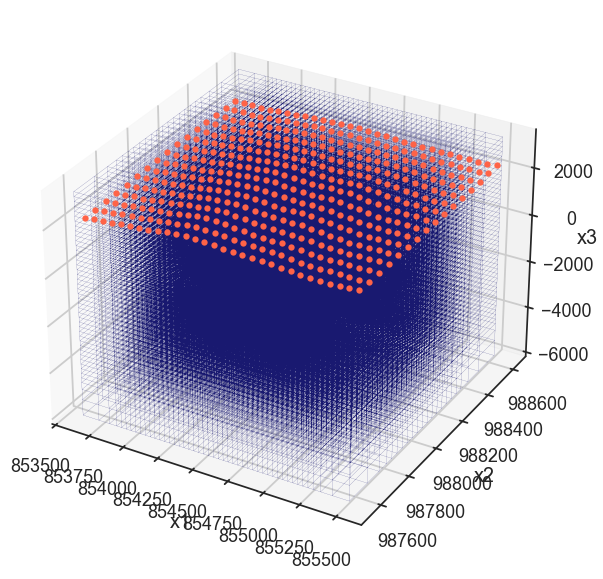

In [15]:
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
meshes = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])
cell_centers = meshes.cell_centers
xy_ravel=cell_centers
                           
meshes.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')



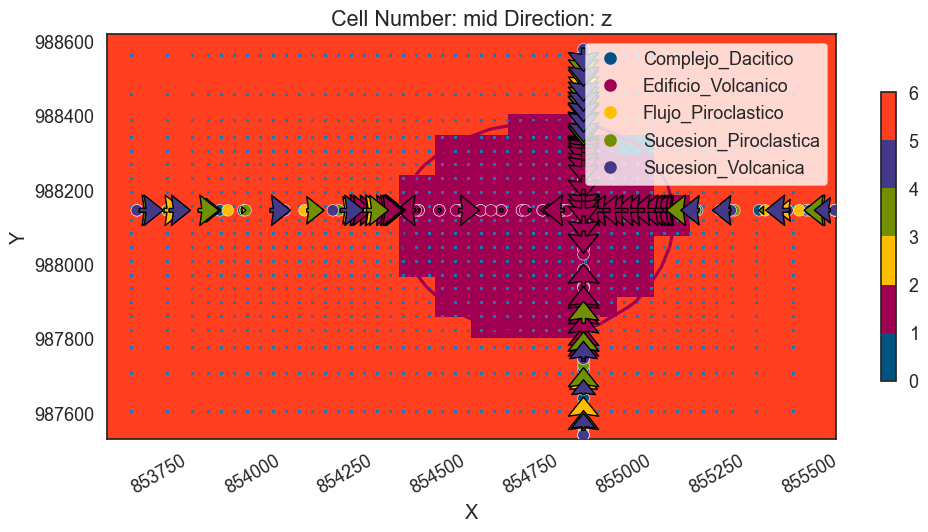

In [16]:
gpv.plot_2d(geo_model, direction='z', show=False)
plt.scatter(xy_ravel[:, 0], xy_ravel[:, 1], s=2) #plotea las columnas X y Y del xy_ravel
plt.show()

In [17]:
array_sol = geo_model.solutions.raw_arrays.lith_block.reshape((20,20,20), order='F')


In [18]:
lith_block = gp.compute_model_at(geo_model, cell_centers)

Active grids: GridTypes.NONE|CUSTOM|DENSE
Setting Backend To: AvailableBackends.numpy
Chunking done: 11 chunks
Chunking done: 27 chunks
Chunking done: 26 chunks
Chunking done: 6 chunks
Chunking done: 13 chunks
Chunking done: 13 chunks


In [19]:
gpv.plot_3d(model=geo_model,
            plotter_type='basic',
            kwargs_plot_structured_grid={'opacity': .6},
            show_surfaces=True,
            show_topography=True,
            show_data=False,
            show_lith=False,
            image=False,
            legend=True,
            # ve=0.1
            )

In [20]:
# Definir los valores de contraste de densidad para cada unidad en g/cm³

background_density = 2.75

densities = {
    0: background_density,  # Densidad del complejo metamórfico (g/cm³) #2.9
    1: 2.45,  # Densidad de Complejo_Dacitico                            #2.2
    2: 2.55,  # Densidad de Cuerpo_Intrusivo                             #2.4
    3: 2.6,  # Densidad de Flujo_Piroclastico                           #2.5
    4: 2.65,  # Densidad de Sucesion_Piroclastica                        #2.6
    5: 2.73  # Densidad de Sucesion_Volcanica                            #2.7
}



# Encontrar los índices para las celdas de malla activas (por ejemplo, celdas debajo de la superficie)
ind_active = active_from_xyz(meshes, topo_xyz)

# Definir el mapeo del modelo a las celdas activas
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Definir el modelo. Los modelos en SimPEG son arrays vectoriales.
model = np.zeros(nC)

# Mapear los valores de contraste de densidad del modelo GemPy al modelo SimPEG
for i, density in densities.items():
    ind_lith = lith_block[ind_active] == i
    model[ind_lith] = density - background_density 





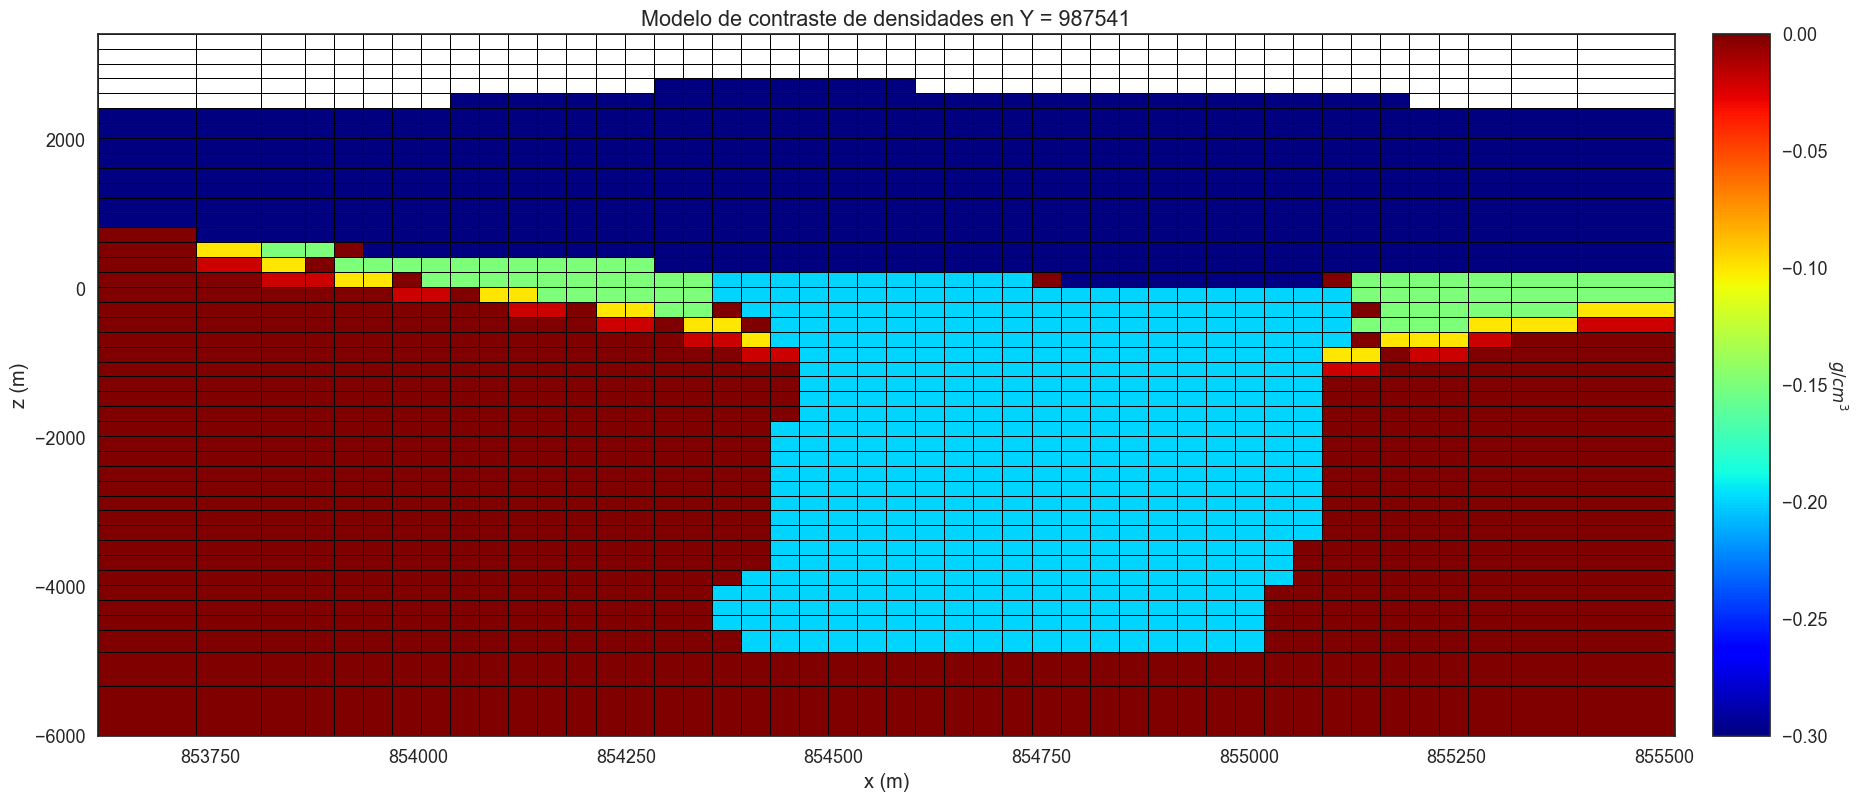

In [21]:
# Visualizar el modelo de contraste de densidad
fig = plt.figure(figsize=(19, 9))
plotting_map = maps.InjectActiveCells(meshes, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.83, 0.78])
meshes.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(meshes.shape_cells[1] / 3),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "jet"},
)
ax1.set_title("Modelo de contraste de densidades en Y = 987541")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.95, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

# plt.savefig('contraste_de_densidad_Y.png', dpi=300)

plt.show()

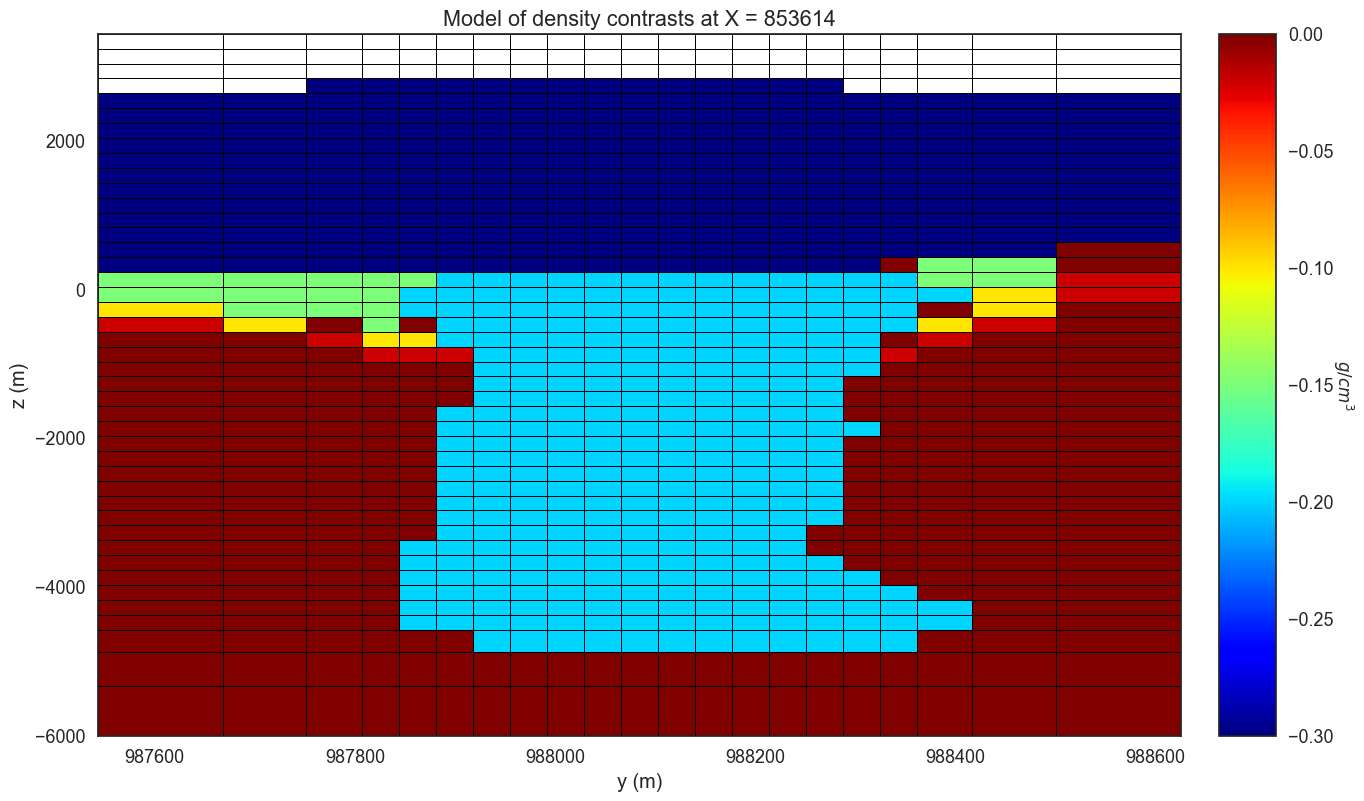

In [22]:
# Visualizar el modelo de contraste de densidad
fig = plt.figure(figsize=(19, 9))
plotting_map = maps.InjectActiveCells(meshes, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.57, 0.78])
meshes.plot_slice(
    plotting_map * model,
    normal="X",
    ax=ax1,
    ind=int(meshes.shape_cells[2] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "jet"},
)
ax1.set_title("Model of density contrasts at X = 853614")
ax1.set_xlabel("y (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.69, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

# plt.savefig('contraste_de_densidad_X.png', dpi=300)

plt.show()

In [23]:
# Configurar el survey (asumiendo que ya lo tienes definido como en tu código anterior)
# survey = gravity.survey.Survey(source_field)

# Crear el problema de gravedad
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=meshes,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
    engine="geoana",
)


# Realizar la simulación directa
d_pred = simulation.dpred(model)


In [24]:
# # Visualizar la anomalía gravitacional predicha
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# # Capturar el objeto retornado por tricontourf
# contour = ax.tricontourf(receiver_locations[:, 0], receiver_locations[:, 1], -d_pred, cmap='jet')

# ax.set_aspect('equal')

# # Pasar el objeto contour a colorbar
# plt.colorbar(contour, label='Gravity Anomaly (mGal)')

# plt.title('Predicted Gravity Anomaly')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()




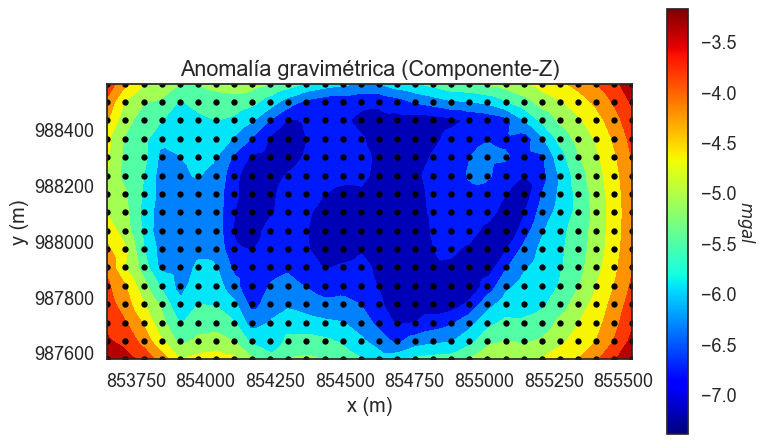

In [25]:
# Plot
from SimPEG.utils import plot2Ddata, model_builder
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, -d_pred, ax=ax1, contourOpts={"cmap": "jet"})
ax1.set_title("Anomalía gravimétrica (Componente-Z)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")


plt.plot(x_topo, y_topo, '.', color='black', )

ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(d_pred)), vmax=np.max(-d_pred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap="jet", #format="%.0e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\potential_fields\gravity\simulation.py:267: RuntimeWarning: invalid value encountered in prism_fz
  node_evals["gz"] = prism_fz(dx, dy, dz)


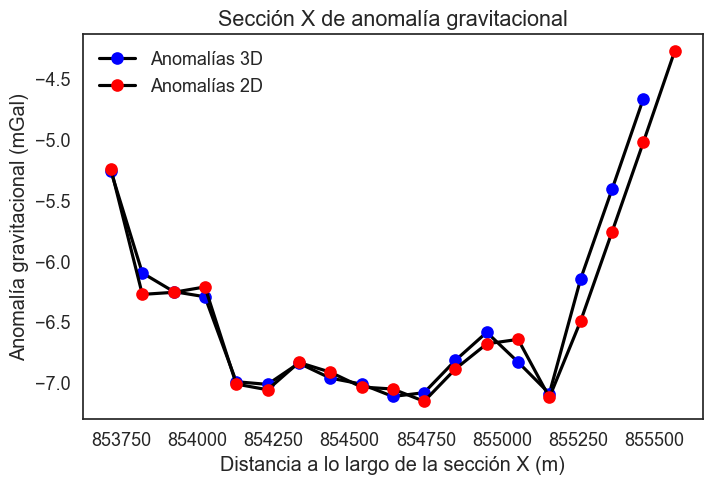

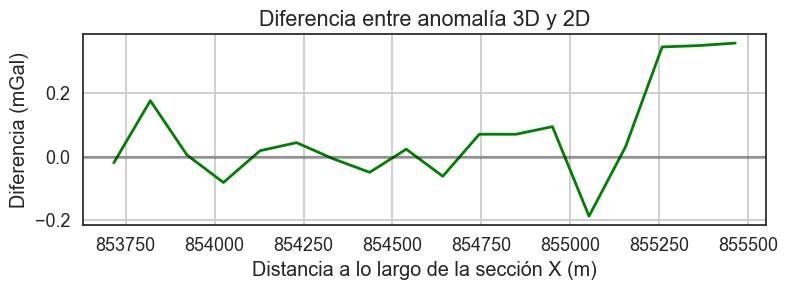

In [26]:
# Asumiendo que tienes tus datos 3D en una variable llamada 'd_pred'
# y las coordenadas x, y, z correspondientes

# Definir la línea de sección (ajusta estos valores según tu necesidad)
x_start, y_start = 853614, 988169  # Coordenadas de inicio
x_end, y_end = 855566, 988169  # Coordenadas de fin

# Crear puntos a lo largo de la línea de sección
num_points = 20
x_section = np.linspace(x_start, x_end, num_points)
y_section = np.linspace(y_start, y_end, num_points)

# Interpolar los valores de anomalía gravitacional a lo largo de la sección
from scipy.interpolate import griddata

points = np.column_stack((receiver_locations[:, 0], receiver_locations[:, 1]))
values = -d_pred
xi = np.column_stack((x_section, y_section))
z_section = griddata(points, values, xi, method='linear')

# Calcular la distancia a lo largo de la sección
distance = np.sqrt((x_section - x_start)**2 + (y_section - y_start)**2) + 853614

# Para la visualización (comentado)
X, Y = np.meshgrid(distance, np.linspace(z_section.min(), z_section.max(), num_points))
Z = np.tile(z_section, (num_points, 1))
# im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='jet')

# Definir la sección 2D
y_section_2d = 988169  # El valor Y de tu sección

# Crear una línea de receptores a lo largo de la sección (en X)
x_range = np.linspace(meshes.x0[0], meshes.x0[0] + meshes.h[0].sum(), 20)
y_range = np.full_like(x_range, y_section_2d)
z_topo = fun_interp(np.c_[x_range, y_range])
receiver_locations_2d = np.c_[x_range, y_range, z_topo + 5.0]

# Crear nuevos receptores y survey para la sección 2D
receiver_list_2d = gravity.receivers.Point(receiver_locations_2d, components=["gz"])
source_field_2d = gravity.sources.SourceField(receiver_list=[receiver_list_2d])
survey_2d = gravity.survey.Survey(source_field_2d)

# Calcular las anomalías gravimétricas para la sección 2D
simulation_2d = gravity.simulation.Simulation3DIntegral(
    survey=survey_2d,
    mesh=meshes,
    rhoMap=maps.IdentityMap(nP=model.size),
    ind_active=ind_active,
)
d_pred_2d = simulation_2d.dpred(model)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(distance, (z_section), color='black', marker="o", markerfacecolor='blue', label="Anomalías 3D")
plt.plot(distance, (-d_pred_2d), color='black', marker="o", markerfacecolor='red', label="Anomalías 2D")
plt.xlabel('Distancia a lo largo de la sección X (m)')
plt.ylabel('Anomalía gravitacional (mGal)')
plt.title('Sección X de anomalía gravitacional')
plt.legend()
# plt.colorbar(im, label='mGal')
plt.show()

# Calcular y mostrar la diferencia entre ambas respuestas
diff = z_section - (-d_pred_2d)
plt.figure(figsize=(8, 3))
plt.plot(distance, diff, 'g-', linewidth=2)
plt.xlabel('Distancia a lo largo de la sección X (m)')
plt.ylabel('Diferencia (mGal)')
plt.title('Diferencia entre anomalía 3D y 2D')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

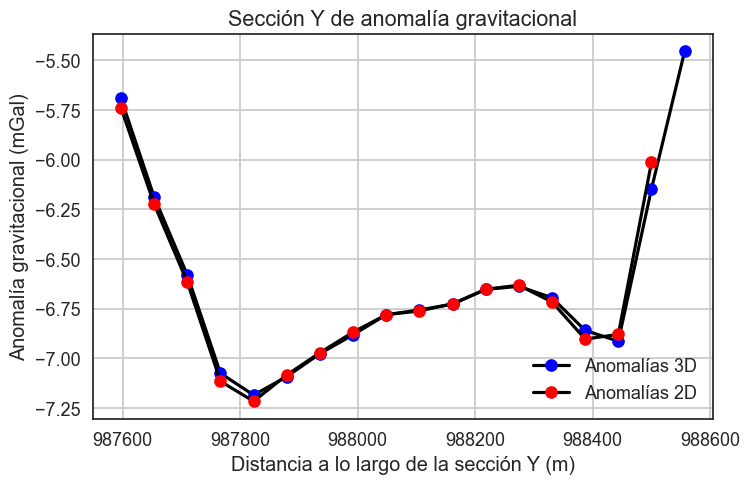

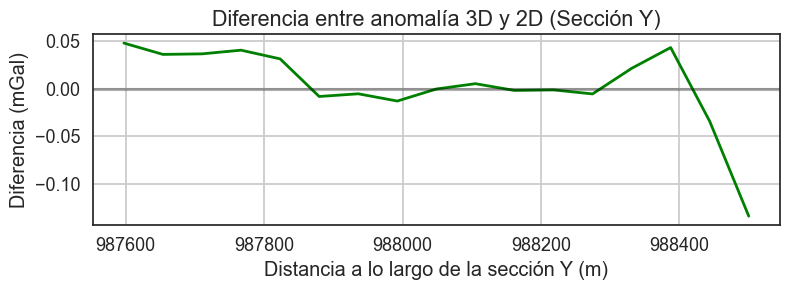

In [27]:
# Definir la línea de sección (sección Y)
x_start, y_start = 854892, 987541  # Coordenadas de inicio
x_end, y_end = 854892, 988613  # Coordenadas de fin

# Crear puntos a lo largo de la línea de sección
num_points = 20
x_section = np.linspace(x_start, x_end, num_points)
y_section = np.linspace(y_start, y_end, num_points)

# Interpolar los valores de anomalía gravitacional a lo largo de la sección
from scipy.interpolate import griddata

points = np.column_stack((receiver_locations[:, 0], receiver_locations[:, 1]))
values = -d_pred
xi = np.column_stack((x_section, y_section))
z_section = griddata(points, values, xi, method='linear')

# Calcular la distancia a lo largo de la sección
distance = np.sqrt((x_section - x_start)**2 + (y_section - y_start)**2) + 987541

# Para la visualización (comentado)
X, Y = np.meshgrid(distance, np.linspace(z_section.min(), z_section.max(), num_points))
Z = np.tile(z_section, (num_points, 1))
# im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='jet')

# Definir la sección 2D
x_section_2d = 854892  # El valor X fijo para la sección

# Crear una línea de receptores a lo largo de la sección (en Y)
y_range = np.linspace(meshes.x0[1], meshes.x0[1] + meshes.h[1].sum(), 20)
x_range = np.full_like(y_range, x_section_2d)
z_topo = fun_interp(np.c_[x_range, y_range])
receiver_locations_2d = np.c_[x_range, y_range, z_topo + 5.0]

# Crear nuevos receptores y survey para la sección 2D
receiver_list_2d = gravity.receivers.Point(receiver_locations_2d, components=["gz"])
source_field_2d = gravity.sources.SourceField(receiver_list=[receiver_list_2d])
survey_2d = gravity.survey.Survey(source_field_2d)

# Calcular las anomalías gravimétricas para la sección 2D
simulation_2d = gravity.simulation.Simulation3DIntegral(
    survey=survey_2d,
    mesh=meshes,
    rhoMap=maps.IdentityMap(nP=model.size),
    ind_active=ind_active,
)
d_pred_2d = simulation_2d.dpred(model)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(distance, (z_section), color='black', marker="o", markerfacecolor='blue', label="Anomalías 3D")
plt.plot(distance, (-d_pred_2d), color='black', marker="o", markerfacecolor='red', label="Anomalías 2D")
plt.xlabel('Distancia a lo largo de la sección Y (m)')
plt.ylabel('Anomalía gravitacional (mGal)')
plt.title('Sección Y de anomalía gravitacional')
plt.legend()
plt.grid(True)
# plt.savefig('comparacion_anomalia_2D_vs_3D_seccion_Y.png', dpi=300)
plt.show()

# Calcular y mostrar la diferencia entre ambas respuestas
diff = z_section - (-d_pred_2d)
plt.figure(figsize=(8, 3))
plt.plot(distance, diff, 'g-', linewidth=2)
plt.xlabel('Distancia a lo largo de la sección Y (m)')
plt.ylabel('Diferencia (mGal)')
plt.title('Diferencia entre anomalía 3D y 2D (Sección Y)')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
# plt.savefig('diferencia_anomalia_2D_vs_3D_seccion_Y.png', dpi=300)
plt.show()



In [28]:
print("Longitud de x_topo:", len(x_topo))
print("Longitud de y_topo:", len(y_topo))
print("Longitud de z_topo:", len(z_topo))
print("Longitud de d_pred:", len(d_pred))

Longitud de x_topo: 480
Longitud de y_topo: 480
Longitud de z_topo: 20
Longitud de d_pred: 480


In [29]:
# Set this to True to save the output
save_output = True

if save_output:
    # Get the current working directory (this should be your JupyterLab working directory)
    current_dir = os.getcwd()
    
    # Create an 'outputs' folder in the current directory if it doesn't exist
    output_dir = os.path.join(current_dir, "outputs")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save topography data
    topo_filename = os.path.join(output_dir, "gravity_topo_480.txt")
    np.savetxt(topo_filename, topo_xyz, fmt="%.4e")
    print(f"Topography data saved to {topo_filename}")

    # Save receiver locations and gravity data
    np.random.seed(737)
    maximum_anomaly = np.max(np.abs(-d_pred))
    noise = 0.1 * maximum_anomaly * np.random.randn(len(d_pred))
    gravity_filename = os.path.join(output_dir, "gravity_data_480_e01.txt")
    np.savetxt(gravity_filename, np.column_stack((receiver_locations, -d_pred + noise)), fmt="%.4e")
    print(f"Gravity data saved to {gravity_filename}")

# Display the full path of the saved files
print(f"\nFiles are saved in the following directory:\n{output_dir}")

Topography data saved to c:\Users\gabri\Downloads\Cosas Wis 8° semestre\SIGAC\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs\gravity_topo_480.txt
Gravity data saved to c:\Users\gabri\Downloads\Cosas Wis 8° semestre\SIGAC\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs\gravity_data_480_e01.txt

Files are saved in the following directory:
c:\Users\gabri\Downloads\Cosas Wis 8° semestre\SIGAC\Inversion&Modelamiento_VCM\Modelamiento_directo\outputs


In [30]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import os

# Asumiendo que tienes:
# receiver_locations: array con las coordenadas x, y de los receptores
# d_pred: array con los valores de anomalía gravitacional predichos

# Primero, vamos a crear una cuadrícula regular de 400 puntos
num_points = 400
x_min, x_max = np.min(receiver_locations[:, 0]), np.max(receiver_locations[:, 0])
y_min, y_max = np.min(receiver_locations[:, 1]), np.max(receiver_locations[:, 1])
z_min, z_max = np.min(receiver_locations[:, 2]), np.max(receiver_locations[:, 2])

x = np.linspace(x_min, x_max, int(np.sqrt(num_points)))
y = np.linspace(y_min, y_max, int(np.sqrt(num_points)))
z = np.linspace(z_min, z_max, int(np.sqrt(num_points)))
xx, yy, zz = np.meshgrid(x, y, z)

# Aplanar las coordenadas x e y
points = np.column_stack((xx.flatten(), yy.flatten(), zz.flatten()))

# Agregar ruido# Interpolar los valores de anomalía gravitacional en estos puntos
values = griddata(receiver_locations[:, :3], -d_pred, points, method='linear')

np.random.seed(737)
maximum_anomaly = np.max(np.abs(d_pred))
noise =  0.01 * maximum_anomaly * np.random.randn(len(values))
noisy_val=values + noise



# Crear un DataFrame con los resultados
df = pd.DataFrame({
    'X': points[:, 0],
    'Y': points[:, 1],
    'Z': points[:, 2],
    'Anomaly': noisy_val
})

# Eliminar filas con valores NaN (si los hay)
df = df.dropna()

# Si hay más de 120 puntos, seleccionar aleatoriamente 120
if len(df) > 1200:
    df = df.sample(n=1000, random_state=42)  # random_state para reproducibilidad

# Guardar en un archivo CSV
df.to_csv('gravity_anomaly_120points.csv', index=False)
print("Datos exportados a 'gravity_anomaly_120points.csv'")

# Mostrar las primeras filas para verificar
print(df.head())

Datos exportados a 'gravity_anomaly_120points.csv'
                  X              Y            Z   Anomaly
5789  854539.683837  988304.062484  2505.933415 -5.667851
7370  854440.473311  988512.483537  2533.954981 -5.464397
5149  855333.368047  988199.851958  2505.933415 -5.144278
1356  854341.262784  987730.904589  2702.084372 -6.177092
7286  854043.631205  988512.483537  2421.868720 -5.111625


In [31]:
print("Tamaño del modelo:", model.size)
print("Dimensiones de la malla:", meshes.shape_cells)
print("Producto de las dimensiones de la malla:", np.prod(meshes.shape_cells))

Tamaño del modelo: 37539
Dimensiones de la malla: (46, 21, 43)
Producto de las dimensiones de la malla: 41538


In [32]:
import vtk
from vtk.util import numpy_support
import numpy as np


# Crear un grid VTK
grid = vtk.vtkStructuredGrid()
grid.SetDimensions(meshes.shape_cells[0], meshes.shape_cells[1], meshes.shape_cells[2])

# Configurar los puntos
points = vtk.vtkPoints()
for i in range(meshes.nC):
    points.InsertNextPoint(meshes.gridCC[i])
grid.SetPoints(points)

# Añadir los datos del modelo
vtkArray = numpy_support.numpy_to_vtk(num_array=model.ravel(), deep=True, array_type=vtk.VTK_FLOAT)
vtkArray.SetName("density_contrast")
grid.GetPointData().AddArray(vtkArray)

# Escribir el archivo
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetFileName("modelo_simepg.vts")
writer.SetInputData(grid)
writer.Write()

print("Modelo exportado a 'modelo_simepg.vts'")

ERROR:root:Point array density_contrast with 1 components, only has 37539 tuples but there are 41538 points
ERROR:root:Input is invalid for piece 0.  Aborting.
ERROR:root:Algorithm vtkXMLStructuredGridWriter (0000025082019740) returned failure for request: vtkInformation (000002508640AA50)


Modelo exportado a 'modelo_simepg.vts'


In [33]:
models = {'density constrast':plotting_map*model}
databse = meshes.to_vtk(models)

In [34]:
databse.save('modelo_simpeg.vtk')